# **Predicción de promedio academico y nivel de estrés en estudiantes usando modelos de Machine Learning.**

**Di Paolo Lafalla, Victoria**  
victoria.dipaolo@mi.unc.edu.ar

**Salvatierra Costa, Baltazar Nicolás**  
salvatierra.baltazar@mi.unc.edu.ar  

**Facultad de Matemática, Astronomía, Física y Computación (FAMAF)**  
**Universidad Nacional de Córdoba**  
Av. Medina Allende y Haya de la Torre - Ciudad Universitaria  
X5016LAE - Córdoba, Argentina


In [ ]:
import numpy as np
import kagglehub
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from mlxtend.plotting import plot_decision_regions
import statsmodels.api as sm

#---------Modelos---------#

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier,VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, ElasticNet

## **Introducción**

En este trabajo analizamos un dataset obtenido a partir de una encuesta realizada a 2000 estudiantes, en la que se consultaba sobre la cantidad de horas dedicadas a distintas actividades diarias, su nivel de estrés y su GPA (Grade Point Average). Una variable clave en este conjunto de datos es el nivel de estrés, que no fue directamente relevada, sino que fue calculada como una función de las respuestas proporcionadas en la encuesta. El objetivo original del dataset, planteado por el creador del mismo, era predecir este nivel de estrés. \\

A partir de este punto de partida, nuestro enfoque fue explorar diferentes modelos y problemas asociados. Inicialmente, intentamos clasificar a los individuos según si su GPA estaba por encima o por debajo del promedio. Luego, reorientamos el análisis hacia una regresión para predecir el GPA de manera continua.
Además, retomamos el problema original de clasificar el nivel de estrés, donde obtuvimos muy buenos resultados, explicados por el carácter determinístico de la variable objetivo. \\

 A lo largo del trabajo, probamos distintos modelos de clasificación y regresión, y analizamos métricas específicas para cada uno, lo que nos permitió evaluar el rendimiento de manera adecuada en cada escenario. En todos los casos, la cantidad de horas de estudio emergió como la variable más relevante dentro del modelo. \\

## **Estudio del dataset**

Este conjunto de datos, titulado "Estilo de vida diario y rendimiento académico de los estudiantes", contiene información de 2.000 estudiantes recopilada a través de una encuesta realizada con Google Forms. Incluye datos sobre horas de estudio, actividades extracurriculares, horas de sueño, vida social, actividad física, niveles de estrés y GPA. La información abarca el año académico desde agosto de 2023 hasta mayo de 2024 y refleja principalmente los estilos de vida de estudiantes en la India. Este conjunto de datos permite analizar el impacto de los hábitos diarios en el rendimiento académico y el bienestar estudiantil.

In [ ]:
# Descargamos el dataset
path = kagglehub.dataset_download("steve1215rogg/student-lifestyle-dataset")
print("Path to dataset files:", path)

# Vemos archivos disponibles
print("Archivos:", os.listdir(path))

# Cargamos el CSV en un DataFrame
df = pd.read_csv(os.path.join(path, "student_lifestyle_dataset.csv"))

Path to dataset files: /kaggle/input/student-lifestyle-dataset
Archivos: ['student_lifestyle_dataset.csv']


In [ ]:
data = df.copy()
data = df.drop(columns=['Student_ID'])

data.head()

,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,8.1,0.6,6.5,2.2,6.6,3.51,High


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Study_Hours_Per_Day              2000 non-null   float64
 1   Extracurricular_Hours_Per_Day    2000 non-null   float64
 2   Sleep_Hours_Per_Day              2000 non-null   float64
 3   Social_Hours_Per_Day             2000 non-null   float64
 4   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 5   GPA                              2000 non-null   float64
 6   Stress_Level                     2000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 109.5+ KB


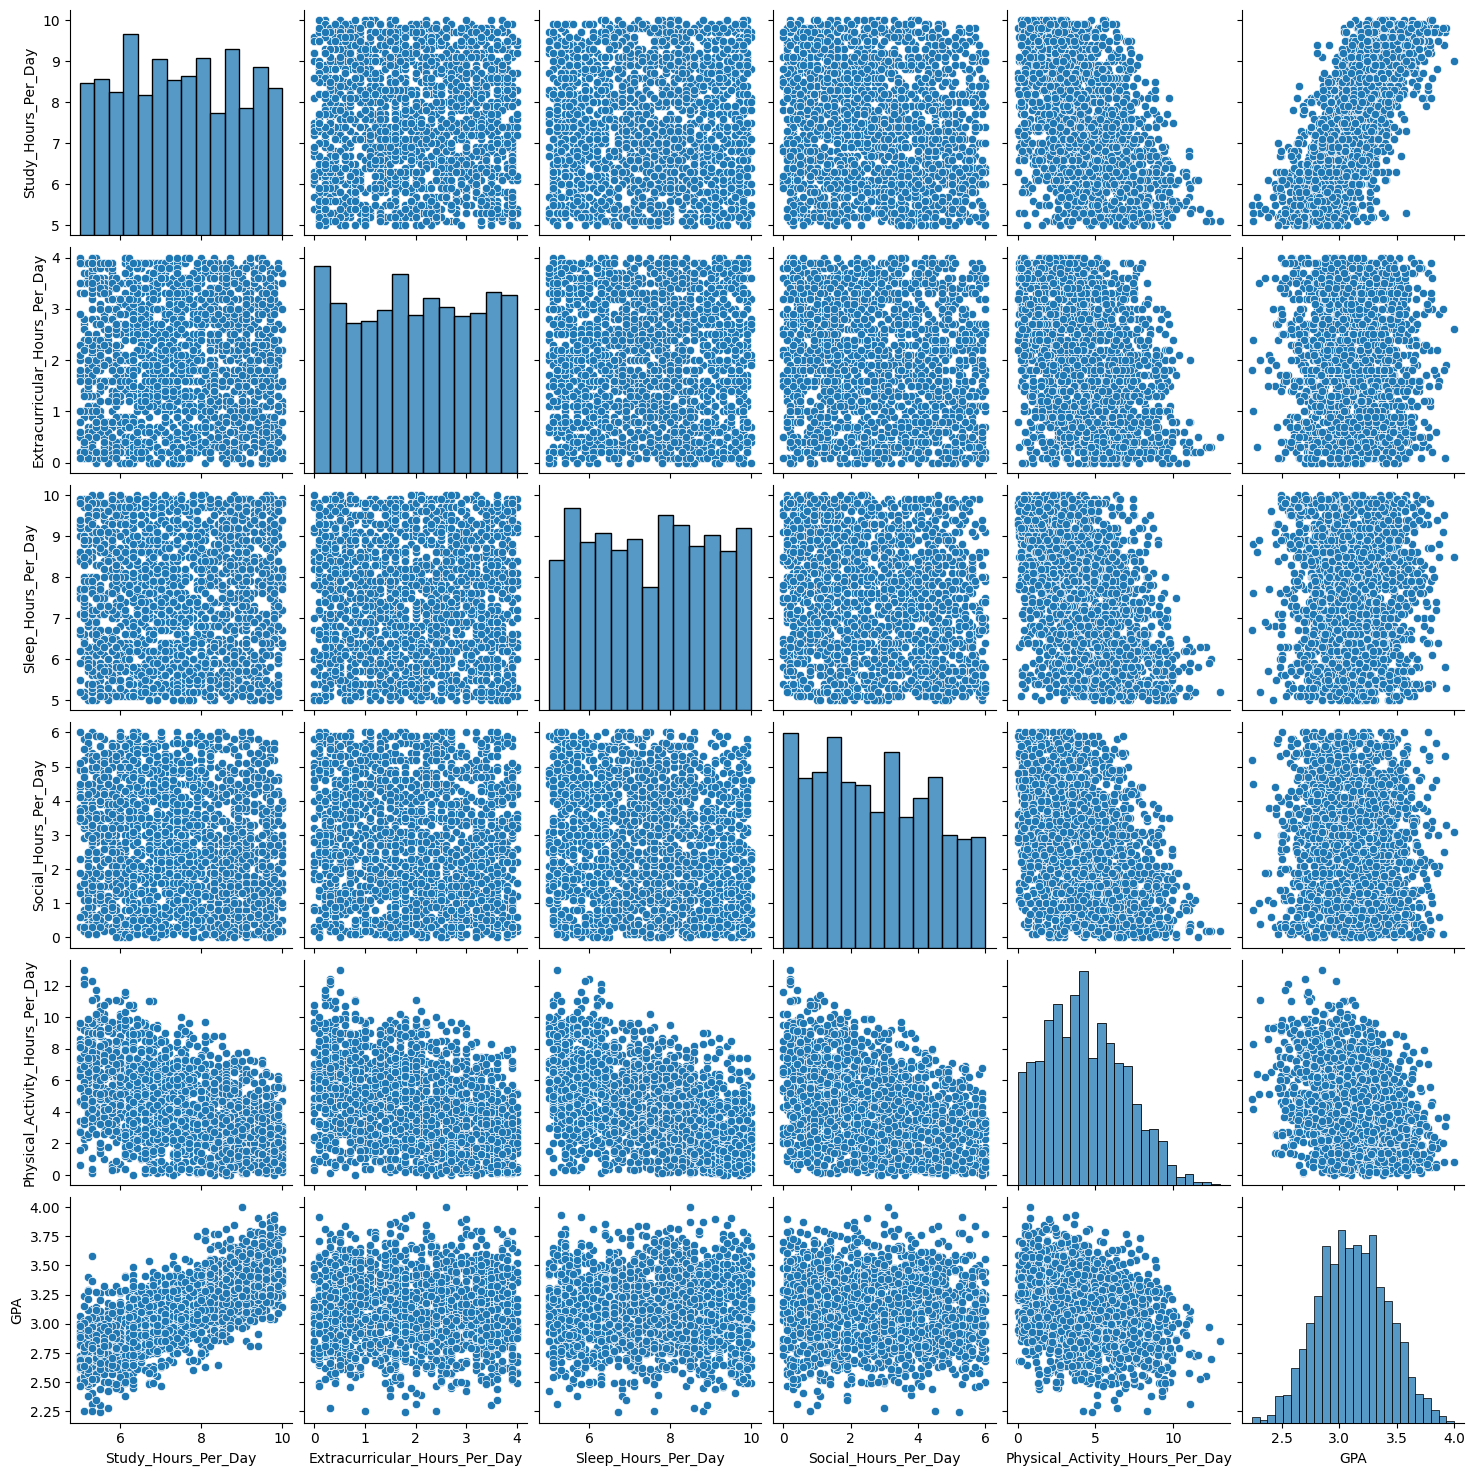

In [ ]:
#Hacemos un pairplot
sns.pairplot(data)

Del pairplot se puede observar la relación aparente entre las horas de estudio diarias y el GPA, así como también el comportamiento gaussiano del GPA.

## **Predicción de estudiantes por encima y por debajo del promedio**

### Análisis preliminar de los datos

Generamos una nueva columna de variable binaria, con valor "1" si el GPA de la persona está por encima del promedio o "0" si no lo está.

In [ ]:
gpa_mean = data['GPA'].mean()
print(f"Promedio de GPA: {gpa_mean:.2f}")

data['GPA_binary'] = (data['GPA'] > gpa_mean).astype(int)

print(data[['GPA', 'GPA_binary']].head())

# Tiramos la columna de GPA
data.drop(columns=['GPA'], inplace=True)

Promedio de GPA: 3.12
    GPA  GPA_binary
0  2.99           0
1  2.75           0
2  2.67           0
3  2.88           0
4  3.51           1


Vemos que las clases están balanceadas.

In [ ]:
# Clases desbalanceadas? -> NO
data['GPA_binary'].value_counts()

,count
GPA_binary,
0,1016
1,984


Definimos nuestra variable target "GPA_binary".

In [ ]:
X=data.drop(columns=['GPA_binary'])
y=data['GPA_binary'] # Variable target
# Usamos stratify para tener el mismo desbalance de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Procesamos las variables categoicas con OneHotEncoder y las numericas con StandarScaler.

In [ ]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categóricas:", categorical_cols)
print("Numéricas:", numerical_cols)

Categóricas: ['Stress_Level']
Numéricas: ['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day', 'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day']


In [ ]:
# Preprocesadores
categorical_transformer = OneHotEncoder()
numerical_transformer = StandardScaler()

# ColumnTransformer aplica cada transformador a su tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ]
)

# Pipeline final
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])

#Fit y transform
preprocessor.fit(X_train)

# Obtenemos nombres de columnas transformadas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(cat_feature_names) + numerical_cols

# Aplicamos la transformación
X_train_proc_array = preprocessor.transform(X_train)
X_test_proc_array = preprocessor.transform(X_test)

# Convertimos a DataFrame con nombres
X_train_proc = pd.DataFrame(X_train_proc_array, columns=all_feature_names, index=X_train.index)
X_test_proc = pd.DataFrame(X_test_proc_array, columns=all_feature_names, index=X_test.index)

### Predicción de alumnos por debajo y por encima del promedio

Comenzamos evaluando los siguientes modelos con tres conjuntos distintos de hiperaparemtros elegidos con el objetivo de abarcar un amplio rango de posibilidades. La idea es ver como cambia la eficiencia de cada modelo al variar los mismos.

Usamos: Logistic Regression, Linear Discriminant Analysis, Support Vector Machine, K Nearest Neighbours, Random Forest y XGBoost.


In [ ]:
param_grids = {
    'Logistic Regression': [
        {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'},
        {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'},
        {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
    ],
    'LDA': [
        {'solver': 'svd', 'shrinkage': None},
        {'solver': 'lsqr', 'shrinkage': None},
        {'solver': 'lsqr', 'shrinkage': 'auto'}
    ],
    'SVM': [
        {'C': 1.0, 'kernel': 'rbf'},
        {'C': 0.1, 'kernel': 'linear'},
        {'C': 10, 'kernel': 'rbf'}
    ],
    'KNN': [
        {'n_neighbors': 5, 'weights': 'uniform', 'p': 2},
        {'n_neighbors': 7, 'weights': 'distance', 'p': 2},
        {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}
    ],
    'Random Forest': [
        {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt'},
        {'n_estimators': 200, 'max_depth': 10, 'max_features': 'sqrt'},
        {'n_estimators': 100, 'max_depth': 5, 'max_features': 'log2'}
    ],
    'XGBoost': [
        {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
        {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05},
        {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}
    ]
}

model_classes = {
    'Logistic Regression': LogisticRegression,
    'LDA': LinearDiscriminantAnalysis,
    'SVM': SVC,
    'KNN': KNeighborsClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}

resultados = []

for model_name, param_list in param_grids.items():
    ModelClass = model_classes[model_name]
    for params in param_list:
        if model_name == 'LDA' and params.get('shrinkage') is None:
            model = ModelClass(solver=params['solver'])
        else:
            model = ModelClass(**params)

        if model_name == 'Logistic Regression':
            model.set_params(max_iter=1000)

        model.fit(X_train_proc, y_train)
        y_pred = model.predict(X_test_proc)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        resultados.append({
            'Modelo': model_name,
            'Hiperparámetros': str(params),
            'Accuracy': round(acc, 4),
            'F1 Score': round(f1, 4)
        })

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(['Modelo', 'Accuracy'], ascending=[True, False])

# Mostramos tabla en consola con formato bonito
print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═════════════════════╤══════════════════════════════════════════════════════════════════╤════════════╤════════════╕
│ Modelo              │ Hiperparámetros                                                  │   Accuracy │   F1 Score │
╞═════════════════════╪══════════════════════════════════════════════════════════════════╪════════════╪════════════╡
│ KNN                 │ {'n_neighbors': 7, 'weights': 'distance', 'p': 2}                │     0.7375 │     0.723  │
├─────────────────────┼──────────────────────────────────────────────────────────────────┼────────────┼────────────┤
│ KNN                 │ {'n_neighbors': 5, 'weights': 'uniform', 'p': 2}                 │     0.7325 │     0.7162 │
├─────────────────────┼──────────────────────────────────────────────────────────────────┼────────────┼────────────┤
│ KNN                 │ {'n_neighbors': 3, 'weights': 'uniform', 'p': 1}                 │     0.7225 │     0.7024 │
├─────────────────────┼─────────────────────────────────────────

Vemos que Logistic Regression y LDA son estables ante el cambio el hiperparametros y dan buen rendimiento. Es por esto que los usaremos como baseline para comparar con otros posibles modelos.

Siendo que Random Forest, SVM y XGBoost tienen variación en sus resultados y no alcanzan a ser los mejores modelos, haremos un Grid Search para ajustar los mejores hiperparametros en cada caso.

Además, descartamos el modelo de KNN debido a su bajo rendimiento.

In [ ]:
# Definimos los hiperparámetros a probar para cada modelo
param_grids = {
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 1, 2, 3, 5],
        'max_features': ['sqrt', 'log2', None],
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
}
# Modelos
models = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

resultados = []

for model_name in models:
    grid = GridSearchCV(models[model_name], param_grids[model_name], cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    grid.fit(X_train_proc, y_train)

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test_proc)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        'Modelo': model_name,
        'Mejores Hiperparámetros': grid.best_params_,
        'Accuracy': acc,
        'F1 Score': f1
    })

df_resultados = pd.DataFrame(resultados)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
╒═══════════════╤═══════════════════════════════════════════════════════════════╤════════════╤════════════╕
│ Modelo        │ Mejores Hiperparámetros                                       │   Accuracy │   F1 Score │
╞═══════════════╪═══════════════════════════════════════════════════════════════╪════════════╪════════════╡
│ SVM           │ {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}                     │     0.77   │   0.741573 │
├───────────────┼───────────────────────────────────────────────────────────────┼────────────┼────────────┤
│ Random Forest │ {'max_depth': 1, 'max_features': 'log2', 'n_estimators': 200} │     0.7725 │   0.750685 │
├───────────────┼───────────────────────────────────────────────────────────────┼────────────┼────────────┤
│ XGBoost       │ {'learning_rate': 0.01, 'max_depth': 3, '

Es llamativo que los modelos complejos, incluso luego de realizar una búsqueda exhaustiva de sus mejores hiperparámetros, sigan sin superar el rendimiento del baseline. Dado este comportamiento, continuamos el análisis con los modelos de base.

Planteamos la hipótesis de que estamos ante un problema simple, con una relación esencialmente lineal o dominado por una única variable altamente predictiva. Esto explicaría por qué los modelos complejos no mejoran su desempeño: tienden a buscar patrones no lineales en un problema donde probablemente no los hay, lo que puede inducir sobreajuste o añadir complejidad innecesaria.

In [ ]:
#Definimos una función para ver la importancia de cada variable en el modelo

def plot_permutation_importance(model, X_test, y_test, feature_names):
    importances = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_indices = importances.importances_mean.argsort()

    plt.figure(figsize=(6, 4))
    plt.barh(range(len(sorted_indices)), importances.importances_mean[sorted_indices], color="skyblue")
    plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
    plt.xlabel("Importancia de la variable")
    plt.title(f"Importancia de cada variable haciendo uso del modelo {model}")
    plt.show()

La **permutation importance** mide cuánto empeora la performance del modelo (por ejemplo, accuracy) cuando se desordena aleatoriamente una variable.

Si al permutar una variable, la performance baja mucho → esa variable es importante.

Si al permutar una variable, la performance casi no cambia → esa variable no es relevante.



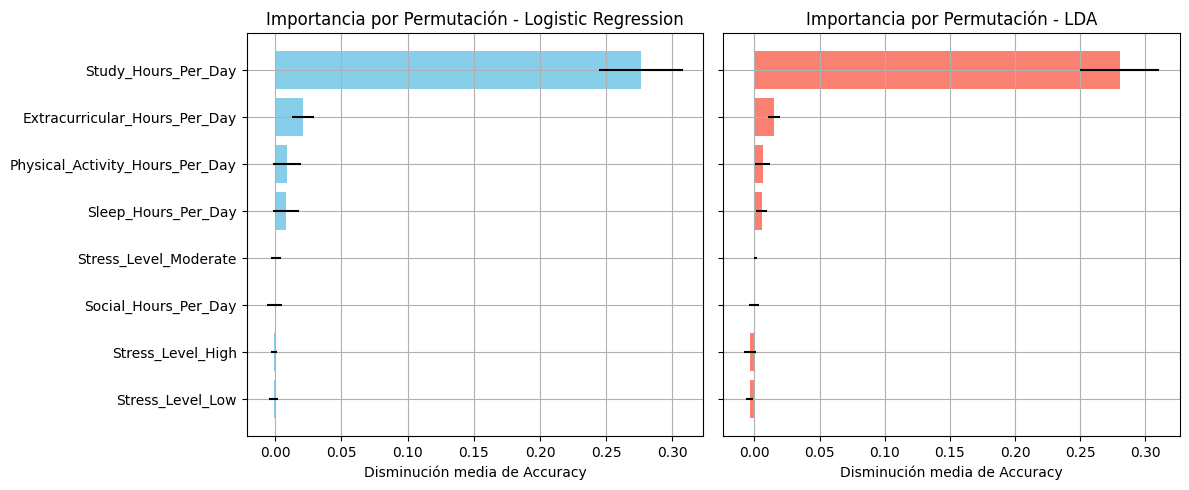

In [ ]:
feature_names = all_feature_names

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_proc, y_train)

# LDA
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train_proc, y_train)

# Calculo importancias por permutación para Logistic Regression
lr_result = permutation_importance(lr_model, X_test_proc, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Calculo importancias por permutación para LDA
lda_result = permutation_importance(lda_model, X_test_proc, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Ordenamos las features por importancia para graficar prolijo
lr_sorted_idx = lr_result.importances_mean.argsort()
lda_sorted_idx = lda_result.importances_mean.argsort()

sorted_idx = lr_result.importances_mean.argsort()
sorted_features = np.array(feature_names)[sorted_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression
axes[0].barh(np.array(feature_names)[lr_sorted_idx], lr_result.importances_mean[lr_sorted_idx],
              xerr=lr_result.importances_std[lr_sorted_idx], color='skyblue')
axes[0].set_title('Importancia por Permutación - Logistic Regression')
axes[0].set_xlabel('Disminución media de Accuracy')
axes[0].grid()

# LDA
axes[1].barh(np.array(feature_names)[lda_sorted_idx], lda_result.importances_mean[lda_sorted_idx],
              xerr=lda_result.importances_std[lda_sorted_idx], color='salmon')
axes[1].set_title('Importancia por Permutación - LDA')
axes[1].set_xlabel('Disminución media de Accuracy')
axes[1].set_yticks(np.arange(len(sorted_features)))
axes[1].set_yticklabels(['' for _ in sorted_features])
axes[1].grid()

plt.tight_layout()
plt.show()

Intenemos hacer una clasificación solamente usando Study Hours per Day.

In [ ]:
X=data[['Study_Hours_Per_Day']]
y=data['GPA_binary'] #Variable target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Lista para guardar resultados
resultados = []

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, C=1, penalty="l2", solver="lbfgs")
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

resultados.append({
    'Modelo': 'Logistic Regression',
    'Accuracy': round(acc_lr, 4),
    'F1 Score': round(f1_lr, 4)
})

# LDA
lda_model = LinearDiscriminantAnalysis(solver='svd')
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)

acc_lda = accuracy_score(y_test, y_pred_lda)
f1_lda = f1_score(y_test, y_pred_lda)

resultados.append({
    'Modelo': 'LDA',
    'Accuracy': round(acc_lda, 4),
    'F1 Score': round(f1_lda, 4)
})


df_resultados = pd.DataFrame(resultados)
print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═════════════════════╤════════════╤════════════╕
│ Modelo              │   Accuracy │   F1 Score │
╞═════════════════════╪════════════╪════════════╡
│ Logistic Regression │       0.77 │     0.7653 │
├─────────────────────┼────────────┼────────────┤
│ LDA                 │       0.77 │     0.7653 │
╘═════════════════════╧════════════╧════════════╛


Sabiendo que cuando solo tenés una única variable predictora, la fórmula de la probabilidad en LDA y Logistic Regression se vuelve equivalente. Graficamos la curva ROC, la distribución de probablidad y la matriz de confusión para LDA.

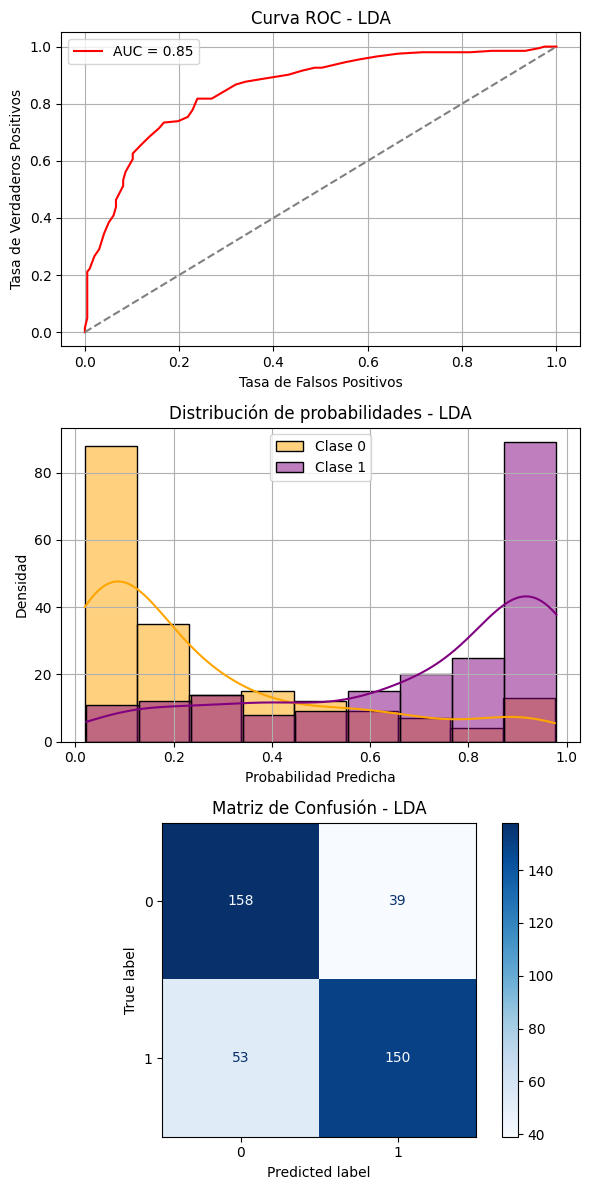

In [ ]:
# Predicciones y probabilidades
y_pred_lda = lda_model.predict(X_test)
y_proba_lda = lda_model.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# Curva ROC
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_proba_lda)
axes[0].plot(fpr_lda, tpr_lda, label=f'AUC = {roc_auc_score(y_test, y_proba_lda):.2f}', color='red')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_xlabel('Tasa de Falsos Positivos')
axes[0].set_ylabel('Tasa de Verdaderos Positivos')
axes[0].set_title('Curva ROC - LDA')
axes[0].legend()
axes[0].grid()

# Distribución de probabilidades
sns.histplot(y_proba_lda[y_test == 0], color='orange', label='Clase 0', kde=True, ax=axes[1], alpha=0.5)
sns.histplot(y_proba_lda[y_test == 1], color='purple', label='Clase 1', kde=True, ax=axes[1], alpha=0.5)
axes[1].set_xlabel('Probabilidad Predicha')
axes[1].set_ylabel('Densidad')
axes[1].set_title('Distribución de probabilidades - LDA')
axes[1].legend()
axes[1].grid()

# Matriz de Confusión
ConfusionMatrixDisplay.from_estimator(lda_model, X_test, y_test, cmap='Blues', ax=axes[2])
axes[2].set_title('Matriz de Confusión - LDA')

plt.tight_layout()
plt.show()


A forma de ilustración, graficamos el umbral para el cual estos modelos deciden si pertenece a una clase o la otra.

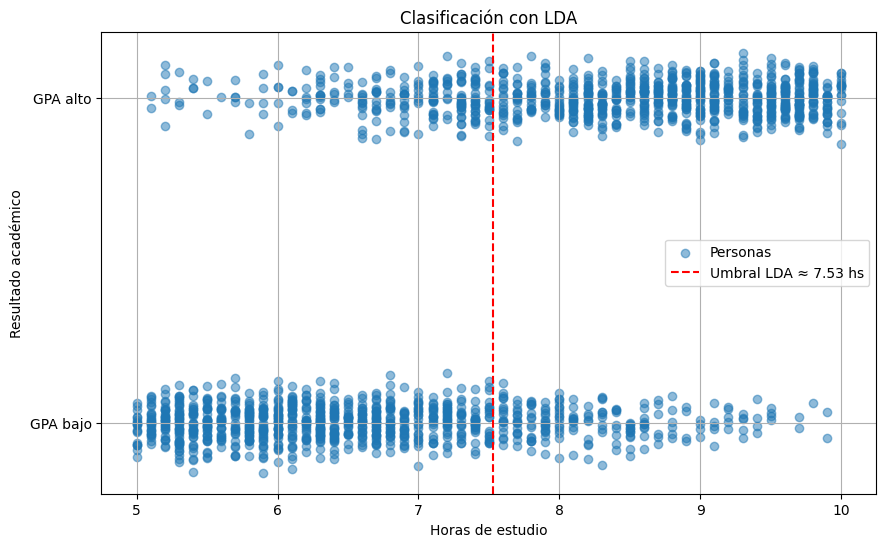

In [ ]:
w0 = lda_model.intercept_[0]
w1 = lda_model.coef_[0][0]
umbral = -w0 / w1

# Agregar jitter a y para mejorar la visualización
jitter = 0.05 * np.random.randn(len(y))
y_jittered = y + jitter

plt.figure(figsize=(10, 6))
plt.scatter(X, y_jittered, alpha=0.5, label='Personas')
plt.axvline(umbral, color='red', linestyle='--', label=f'Umbral LDA ≈ {umbral:.2f} hs')
plt.yticks([0, 1], ['GPA bajo', 'GPA alto'])
plt.xlabel('Horas de estudio')
plt.ylabel('Resultado académico')
plt.title('Clasificación con LDA')
plt.legend()
plt.grid(True)
plt.show()

### Análisis de resultados de la predicción de estudiantes por encima y por debajo del promedio

Inicialmente probamos distintos modelos, cada uno con tres configuraciones de hiperparámetros. A partir de esos resultados, establecimos como baseline los modelos de LDA y Logistic Regression, ya que no solo obtuvieron el mejor rendimiento, sino que también demostraron mayor robustez frente a cambios en los hiperparámetros.

Luego, intentamos mejorar el rendimiento de modelos más complejos como SVM, Random Forest y XGBoost, aplicando una búsqueda con grid search sobre un rango amplio de hiperparámetros. Sin embargo, no se observó ninguna mejora significativa.

Este comportamiento sugiere que la frontera de decisión que separa las clases es aproximadamente lineal. En consecuencia, aplicar modelos no lineales con kernels o estructuras más complejas puede resultar en sobreajuste o simplemente añadir complejidad donde no se necesita.

Para verificar esta hipótesis, utilizamos la función permutation_importance, que indicó que la variable horas de estudio tiene un peso predictivo significativamente mayor que el resto. Al eliminar todas las demás variables y entrenar nuevamente los modelos de base, observamos que el rendimiento se mantenía prácticamente igual.

Además, al evaluar el modelo utilizando la curva ROC, obtuvimos un AUC de 0.85, lo cual indica una excelente capacidad discriminativa incluso con una sola variable predictora. La matriz de confusión mostró que el modelo predice de manera equilibrada ambas clases (0 y 1), sin evidenciar un sesgo sistemático hacia ninguna de ellas.

Esto nos lleva a concluir que el problema puede ser clasificado con eficiencia cercana al baseline utilizando una única variable predictora, y que la simplicidad del modelo está en línea con la estructura real y subyacente del problema.

## **Regresión para la predicción directa del promedio del alumno**

### Análisis preliminar de los datos

In [ ]:
data_reg = df.copy()

X = data_reg.drop(columns=["GPA", "Student_ID"])
y = data_reg["GPA"]

# One-hot encoder para 'Stress_Level'
ohe = OneHotEncoder(drop=None)
X_encoded = ohe.fit_transform(X[["Stress_Level"]])
encoded_cols = ohe.get_feature_names_out(["Stress_Level"])
encoded_data = X_encoded.toarray()
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols)

#Saco la columna anterior y pongo las del ohe
X = pd.concat([X.drop(columns=["Stress_Level"]), encoded_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

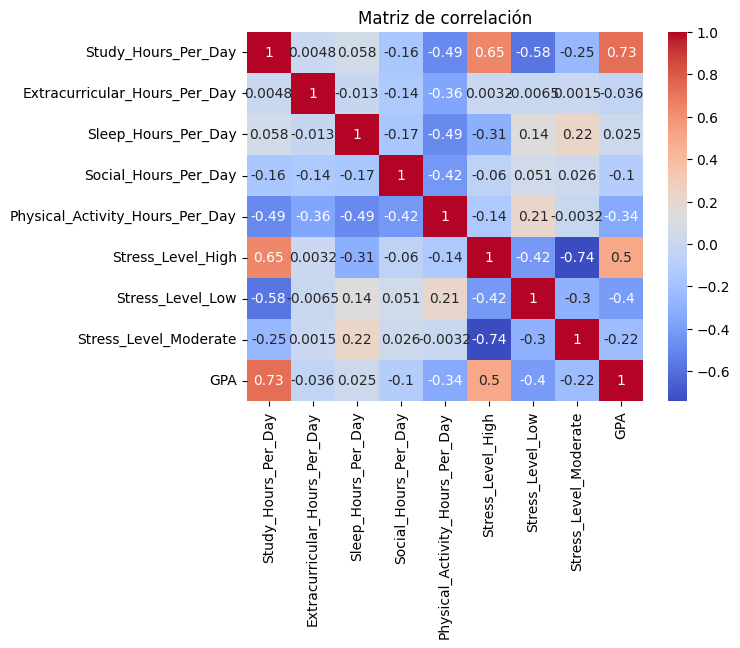

In [ ]:
data_reg = pd.concat([X_train, y_train], axis=1)
corr_matrix = data_reg.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

Analizando la matriz de correlación, se identifican como variables relevantes para predecir el GPA la cantidad de horas de estudio y el nivel de estrés. Sin embargo, dado que el nivel de estrés es una variable determinística (calculada a partir de otras variables), decidimos excluirla del modelo de regresión para evitar redundancias, quedando únicamente las horas de estudio como variable predictora.

Este resultado esta en linea con lo visto con la función de importancia, verificando que la unica variable significativamente correlacionada con el GPA son las horas de estudio.

Graficamos el GPA en función de las horas de estudio. A modo de ilustración discriminamos con distintos colores el nivel de estrés de los estudiantes.

In [ ]:
data_reg1=df.copy()

X = data_reg1.drop(columns=["GPA", "Student_ID"])
y = data_reg1["GPA"]

X= X[["Study_Hours_Per_Day"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<Axes: xlabel='Study_Hours_Per_Day', ylabel='GPA'>

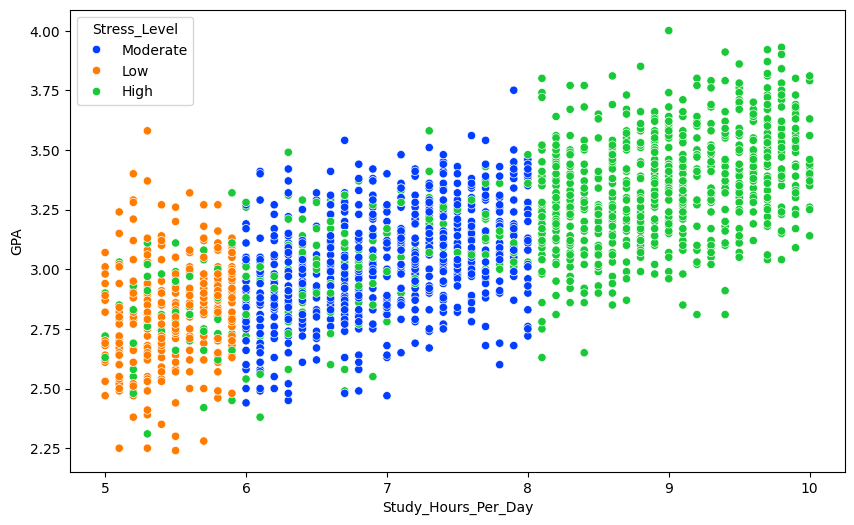

In [ ]:
#Grafico GPA en termino de Study Hours con un hue de stress
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_reg1, x='Study_Hours_Per_Day', y='GPA', hue='Stress_Level', palette='bright')

En el grafico se ve claramente una tendencia lineal entre el GPA y las horas de estudio, y una tendencia ascendente con el nivel de estrés.

###Predicción del GPA como variable contínua

Comenzamos evaluando los siguientes modelos con distintos de hiperaparemtros elegidos aleatoriamente. La idea es ver como cambia la eficiencia de cada modelo al variar los mismos.

Usamos: Linear Regression, Ridge, Lasso y ElasticNet.

In [ ]:
# Lista de modelos con hiperparámetros fijos
models = [
    LinearRegression(),
    Ridge(alpha=0.001),
    Lasso(alpha=0.1),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
]

resultados = []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados.append({
        'Modelo': model.__class__.__name__,
        'MAE': mae,
        'R²': r2
    })

# Convertimos a DataFrame y ordenamos por R² descendente
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='R²', ascending=False).reset_index(drop=True)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒══════════════════╤══════════╤══════════╕
│ Modelo           │      MAE │       R² │
╞══════════════════╪══════════╪══════════╡
│ LinearRegression │ 0.164412 │ 0.550098 │
├──────────────────┼──────────┼──────────┤
│ Ridge            │ 0.164412 │ 0.550098 │
├──────────────────┼──────────┼──────────┤
│ ElasticNet       │ 0.169214 │ 0.528327 │
├──────────────────┼──────────┼──────────┤
│ Lasso            │ 0.177247 │ 0.487134 │
╘══════════════════╧══════════╧══════════╛


Debido a que todos tienen rendimientos similares, vamos a realizar un Grid Search para ver si mejor el desempeño de los regresores.

In [ ]:
# Definimos los modelos y sus grids
param_grids = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.001, 0.1, 1, 10]}
    },
    'Lasso': {
        'model': Lasso(max_iter=10000),
        'params': {'alpha': [0.001, 0.01, 0.1, 1, 10]}
    },
    'ElasticNet': {
        'model': ElasticNet(max_iter=10000),
        'params': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
    },
}

resultados = []

# Evaluamos Linear Regression sin hiperparámetros
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

resultados.append({
    'Modelo': 'LinearRegression',
    'Mejores Parámetros': 'Default',
    'MAE': mae,
    'R²': r2
})

# Grid Search para los otros modelos
for name, config in param_grids.items():
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=3,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    resultados.append({
        'Modelo': name,
        'Mejores Parámetros': str(best_params),
        'MAE': mae,
        'R²': r2
    })

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='R²', ascending=False).reset_index(drop=True)

print(tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False))


╒══════════════════╤═══════════════════════════════════╤══════════╤══════════╕
│ Modelo           │ Mejores Parámetros                │      MAE │       R² │
╞══════════════════╪═══════════════════════════════════╪══════════╪══════════╡
│ LinearRegression │ Default                           │ 0.164412 │ 0.550098 │
├──────────────────┼───────────────────────────────────┼──────────┼──────────┤
│ Ridge            │ {'alpha': 1}                      │ 0.164417 │ 0.550091 │
├──────────────────┼───────────────────────────────────┼──────────┼──────────┤
│ ElasticNet       │ {'alpha': 0.001, 'l1_ratio': 0.1} │ 0.164424 │ 0.55008  │
├──────────────────┼───────────────────────────────────┼──────────┼──────────┤
│ Lasso            │ {'alpha': 0.001}                  │ 0.164464 │ 0.550018 │
╘══════════════════╧═══════════════════════════════════╧══════════╧══════════╛


Dado que Ridge, Lasso y ElasticNet son extensiones del modelo de regresión lineal con regularización, es esperable que, tras una búsqueda de hiperparámetros, todos tiendan a un comportamiento similar, en este caso al de Linear Regression (cuando la penalización óptima es cercana a cero). Esto ocurre cuando la regularización no aporta mejoras significativas al modelo. En estos casos, la solución óptima de los modelos regularizados converge a la solución de mínimos cuadrados ordinarios, explicando por qué el desempeño final es comparable al del modelo de regresión lineal simple.

El modelo obtenido presenta un coeficiente de determinación 0.55, lo cual indica que aproximadamente el 55% de la variabilidad en el GPA es explicada por la variable horas de estudio.

Viendo que haciendo Grid Search el desempeño de los regresores es muy similar entre ellos, por lo que nos quedamos con 'Linear Regressor' por su simplicidad y bajo costo computacional.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


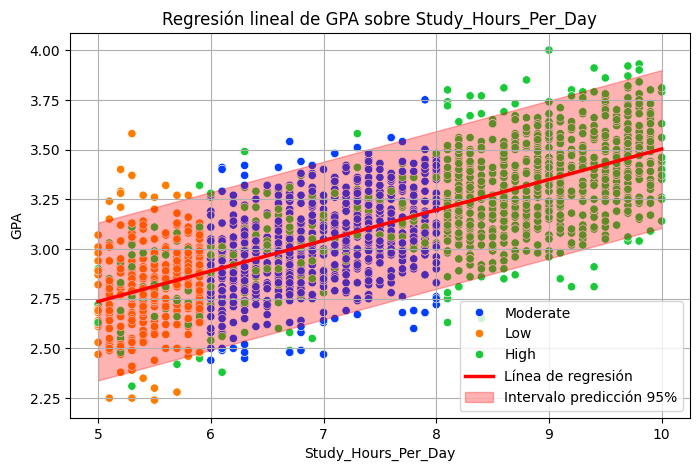

In [ ]:
# Entrenamos el modelo lineal
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
y_train_pred = model_linear.predict(X_train)

plt.figure(figsize=(8, 5))

# Graficamos los datos reales con hue por Stress_Level
sns.scatterplot(data=data_reg1, x='Study_Hours_Per_Day', y='GPA', hue='Stress_Level', palette='bright')

X_plot = np.linspace(X_train['Study_Hours_Per_Day'].min(), X_train['Study_Hours_Per_Day'].max(), 100)
X_plot_reshaped = X_plot.reshape(-1, 1)

# Predicción de la línea de regresión
y_plot = model_linear.predict(X_plot_reshaped)

# Ajustamos modelo statsmodels para intervalo de confianza y predicción
X_sm = sm.add_constant(X_train['Study_Hours_Per_Day'])
model_sm = sm.OLS(y_train, X_sm).fit()

X_plot_sm = sm.add_constant(X_plot)
preds = model_sm.get_prediction(X_plot_sm)
pred_summary = preds.summary_frame(alpha=0.05)

# Graficamos línea de regresión
plt.plot(X_plot, y_plot, color="red", label="Línea de regresión", lw=2.5)

# Graficamos el intervalo de predicción para nuevas observaciones
plt.fill_between(X_plot, pred_summary['obs_ci_lower'], pred_summary['obs_ci_upper'], color='red', alpha=0.3, label='Intervalo predicción 95%')

plt.xlabel('Study_Hours_Per_Day')
plt.ylabel("GPA")
plt.title(f"Regresión lineal de GPA sobre Study_Hours_Per_Day")
plt.legend()
plt.grid(True)
plt.show()


###Análisis de resultados de la regresión del GPA

Se utilizó como unica variable predictora la cantidad de horas de estudio diarias. \\

Una vez realizada la regresión, se visualizó la distribución de los puntos según el nivel de estrés. Se observa que los puntos correspondientes a niveles de estrés bajo y moderado se encuentran en zonas de notas moderadas y bajas, muy próximos, sin mezclarse, delimitados por un umbral claro que separa ambas categorías. Por otro lado, los casos con nivel de estrés alto predominan en la zona de notas altas, también mostrando un umbral bien definido; sin embargo, existe una dispersión homogénea de puntos con estrés alto a lo largo de todo el rango de datos. \\

El modelo obtenido presenta un coeficiente de determinación R² = 0.55, lo cual indica que aproximadamente el 55% de la variabilidad en el GPA es explicada por la variable "horas de estudio por día". Este resultado es especialmente relevante considerando que el modelo utiliza únicamente una característica predictora.

En problemas del ámbito educativo, social o conductual, es habitual encontrar múltiples factores que influyen sobre la variable objetivo, muchos de los cuales no se encuentran disponibles o no son observables (por ejemplo, motivación personal, calidad del estudio, contexto familiar, estado emocional, entre otros). Por esta razón, alcanzar valores de R² cercanos a 1 en estos contextos es poco frecuente y, en cambio, valores en el rango de 0.4 a 0.6 suelen ser considerados buenos indicadores de capacidad predictiva cuando se trabaja con modelos simples o con pocas variables (Gelman & Hill, 2007; Cohen et al., 2003).

En este caso particular, el hecho de que con una sola variable explicativa se logre un R² de 0.55 sugiere que las horas de estudio por día tienen un impacto fuerte y directo sobre el GPA, capturando gran parte de la tendencia del fenómeno. Este valor refleja que el modelo no solo es adecuado para explicar la relación entre las variables, sino que también proporciona una herramienta predictiva útil y con una interpretación sencilla.

En resumen, el R² obtenido es satisfactorio para el tipo de problema abordado y para la simplicidad del modelo empleado.


## **Predicción de el nivel de estrés de los estudiantes**

### Análisis preeliminar de los datos

Comenzamos preparando el dataset haciendo un análisis similar a cuando calculamos el GPA solo que cambiando la variable objetivo.

In [ ]:
data_stress=df.copy()

X=data_stress.drop(columns=['Stress_Level'])
y=data_stress['Stress_Level'] #Variable target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [ ]:
#Como solo tenemos variables numericas en el X_train, estandarizamos
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

X_train_stress = numeric_transformer.fit_transform(X_train)
X_test_stress = numeric_transformer.transform(X_test)

###Predicción de nivel de estrés

Inicialmente probamos la eficiencia de los mismos modelos que usamos a la hora de clasificar estudiantes por encima y por debajo del promedio.

In [ ]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "LDA": LinearDiscriminantAnalysis(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

results_stress = []

for name, model in classifiers.items():
    model.fit(X_train_stress, y_train)
    y_pred = model.predict(X_test_stress)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results_stress.append((name, acc, f1))

results_stress = pd.DataFrame(results_stress, columns=['Modelo', 'Accuracy', 'F1 Score'])
results_stress = results_stress.sort_values(by='F1 Score', ascending=False)

print("\n📊 Comparación de modelos:")
print(tabulate(results_stress, headers='keys', tablefmt='fancy_grid', showindex=False))


📊 Comparación de modelos:
╒═════════════════════╤════════════╤════════════╕
│ Modelo              │   Accuracy │   F1 Score │
╞═════════════════════╪════════════╪════════════╡
│ Random Forest       │     1      │   1        │
├─────────────────────┼────────────┼────────────┤
│ Gradient Boosting   │     1      │   1        │
├─────────────────────┼────────────┼────────────┤
│ AdaBoost            │     0.965  │   0.966266 │
├─────────────────────┼────────────┼────────────┤
│ SVM                 │     0.93   │   0.928983 │
├─────────────────────┼────────────┼────────────┤
│ Logistic Regression │     0.8075 │   0.805896 │
├─────────────────────┼────────────┼────────────┤
│ LDA                 │     0.79   │   0.7895   │
╘═════════════════════╧════════════╧════════════╛


### Análisis de los resultados de la predicción de nivel de estrés

Para clasificación del nivel de estrés, categorizado en bajo, moderado y alto, se obtuvieron resultados de accuracy igual a 1 para los métodos adaptativos, mientras que para LDA alcanzó 0,77. Este comportamiento es esperable dado que el nivel de estrés en el dataset (obtenido a partir de una encuesta) fue calculado como una función de las propias respuestas proporcionadas por los participantes, lo que introduce un carácter determinístico en la variable objetivo. \\

El hecho de que LDA no logre un rendimiento perfecto puede atribuirse a que la relación entre las respuestas de la encuesta y el nivel de estrés no es estrictamente lineal, lo cual limita la capacidad de este método lineal para separar las clases de manera exacta. En cambio, los métodos adaptativos, al ser más flexibles, logran capturar con mayor precisión la estructura subyacente en los datos.


Los resultados obtenidos al aplicar los modelos entrenados al dataset de la encuesta realizada en FAMAF evidencian un bajo desempeño predictivo. En particular, el modelo tiende a subestimar las notas de los estudiantes, lo que sugiere que las horas de estudio no explican con precisión el rendimiento académico en esta muestra.

Además, la fórmula utilizada para calcular el nivel de estrés en el dataset original no ajusta correctamente a los datos relevados en FAMAF. Esto puede deberse tanto a limitaciones en la formulación original como a la subjetividad del estrés autopercibido en la nueva encuesta.

Estas diferencias de desempeño son esperables, dado que el dataset FAMAF no pertenece al conjunto original y no conocemos con detalle el criterio de recolección de los datos de origen. El modelo original fue entrenado en un contexto específico y bajo definiciones particulares de las variables, mientras que en la encuesta propia el nivel de estrés fue autopercibido, introduciendo variabilidad no considerada previamente.

En conclusión, el bajo rendimiento de los modelos sobre el nuevo conjunto de datos resalta la importancia de adaptar y validar los modelos para cada contexto particular, especialmente cuando las variables clave cambian en su definición o forma de medición.

##**Conclusión**

Este trabajo abordó cuatro ejes principales vinculados a la predicción del rendimiento académico y el nivel de estrés en estudiantes, a partir de datos de encuestas estructuradas.

1. Clasificación de estudiantes por rendimiento

  Se compararon modelos de clasificación para predecir si un estudiante se encuentra por encima o por debajo del promedio académico. Logistic Regression y LDA resultaron ser los modelos más eficaces, superando a métodos más complejos como SVM, Random Forest y XGBoost, incluso tras aplicar búsqueda de hiperparámetros. La simplicidad del problema, dominado por una única variable predictora fuerte, justificó el buen desempeño de modelos lineales. El modelo mostró un AUC de 0.85 y una predicción equilibrada entre clases.

2. Regresión para predecir el GPA

  Se construyó un modelo de regresión lineal utilizando únicamente la variable “horas de estudio por día”, excluyendo el nivel de estrés por su naturaleza determinística. Se obtuvo un coeficiente de determinación R² = 0.55, un valor satisfactorio para un modelo univariado en un contexto educativo, lo que sugiere un impacto fuerte y directo de esa variable sobre el GPA.

3. Clasificación del nivel de estrés

  Se evaluó la predicción del nivel de estrés (bajo, moderado, alto), observándose un accuracy perfecto en modelos como XGBoost, dada la naturaleza de esta variable en el dataset original (calculada a partir de otras variables). LDA, al ser un modelo lineal, alcanzó un desempeño menor (accuracy = 0.77) lo cual sugiere que la ecuación utilizada para el cálculo del nivel de estrés es de caracter no lineal.

En conjunto, este trabajo exploró la relación entre las horas de estudio, el rendimiento académico y el nivel de estrés en estudiantes, comparando distintos enfoques de clasificación y regresión.